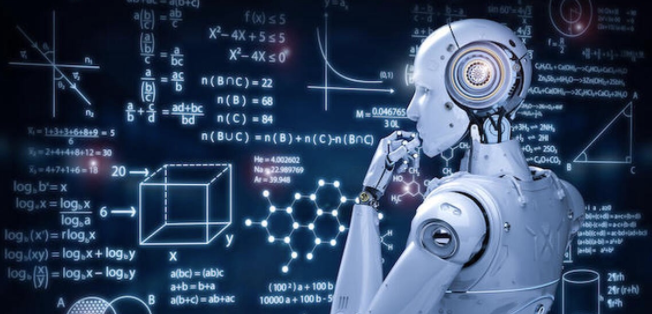  



#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-cat-modeless)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

import random
import os

SEED = 2021
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder

from scipy.stats.mstats import gmean, hmean
from numpy import mean, median

# Read data

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
df_train_idx = df_train.index
df_test_idx = df_test.index

# x, y, direction -> road

In [ ]:
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])

df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

# Missing time points
* There are 81 of them, let's fill in with means, see [here](https://www.kaggle.com/martynovandrey/tps-mar-22-fe-the-less-the-better) for details and visualisation

In [ ]:
# +0 public score

def tic_to_time(tic):
    t = pd.to_datetime('1990-12-31 00:00') + pd.Timedelta(pd.offsets.Minute(tic*20))
    return pd.to_datetime(t)

def add_tics(df):
    df['tic'] = df['time'].dt.dayofyear * 72 + df['time'].dt.hour * 3 + df['time'].dt.minute // 20

def fill_missing_time(df_train):
    df = df_train[['time', 'road', 'congestion']]
    df['imputed'] = False
    add_tics(df)
    unique_tics = list(df.tic.unique())
    
    for tic in range(df.tic.min(), df.tic.max()+1):
        if not tic in unique_tics:
            pred, nxt = tic, tic
            while not pred in unique_tics:
                pred = int(pred - 1)
            while not nxt in unique_tics:
                nxt = int(nxt + 1)
            df_pred = df[df.tic == pred]
            df_next = df[df.tic == nxt]

            tmp = pd.concat([df_pred, df_next], axis=0)
            tmp_mean = tmp.drop(['time', 'imputed', 'tic'], axis=1).groupby(['road']).mean().reset_index()
            tmp_mean['congestion'] = tmp_mean['congestion'].round().astype(int)
            tmp_mean['tic'] = tic
            tmp_mean['time'] = tic_to_time(tic)
            tmp_mean['imputed'] = True
            tmp_mean = tmp_mean[df.columns].drop_duplicates()
            df = pd.concat([df, tmp_mean], axis=0)
    df = df.sort_values(by=['tic', 'road'])
    df = df.drop(['tic'], axis=1)
    return df

# df_train = fill_missing_time(df_train)
# df_train = df_train.drop(['imputed'], axis=1)

# train = train.reset_index(drop=True)

# Outliers

### Labor day
* Thanks [wti200](https://www.kaggle.com/wti200) for the idea

In [ ]:
# # +0.022 public score, removed
# labor_day = pd.to_datetime('1991-09-02').dayofyear
# df_train = df_train[df_train['time'].dt.dayofyear != labor_day]

# # with labor day
# MLR              ModellessRegressor test = 5.120
# GBR       GradientBoostingRegressor test = 4.888
# CAT               CatBoostRegressor test = 4.857
# LGBM                  LGBMRegressor test = 5.016
#                     VotingRegressor test = 4.853
#                             BLENDED test = 4.891
# # without
# MLR              ModellessRegressor test = 5.115 -0.005
# GBR       GradientBoostingRegressor test = 4.881 -0.007
# CAT               CatBoostRegressor test = 4.863 +0.006
# LGBM                  LGBMRegressor test = 5.042 **+0.026**
#                     VotingRegressor test = 4.852 -0.001  
#                             BLENDED test = 4.895 +0.004  

# Mondays only
* leave only mondays

In [ ]:
# df_train = df_train[df_train.time.dt.weekday == 0]

# MLRmd             ModellessRegressor mae = 5.156
# GBR        GradientBoostingRegressor mae = 4.898
# CAT                CatBoostRegressor mae = 4.888
# LGBM                   LGBMRegressor mae = 5.034
#                      VotingRegressor mae = 4.875
#                             BLENDED test = 4.929

# Feature Engineering

### Date and time features

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 

In [ ]:
add_datetime_features(df_train)
add_datetime_features(df_test)

### Morning congestion averages

In [ ]:
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')

### Congestion Min, Max, Median

In [ ]:
mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
# # public sore +0.005, removed
# stds = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.std().astype(int)).reset_index()
# stds = stds.rename(columns={'congestion':'std'})
# df_train = df_train.merge(stds, on=['road', 'weekday', 'hour', 'minute'], how='left')
# df_test = df_test.merge(stds, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
# quantile25 = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.quantile([.25]).astype(int)).reset_index()
# quantile25 = quantile25.rename(columns={'congestion':'quantile25'}).drop(['level_4'], axis=1)
# df_train = df_train.merge(quantile25, on=['road', 'weekday', 'hour', 'minute'], how='left')
# df_test = df_test.merge(quantile25, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
# quantile75 = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.quantile([.75]).astype(int)).reset_index()
# quantile75 = quantile75.rename(columns={'congestion':'quantile75'}).drop(['level_4'], axis=1)
# df_train = df_train.merge(quantile75, on=['road', 'weekday', 'hour', 'minute'], how='left')
# df_test = df_test.merge(quantile75, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
important_features = ['moment', 'median', 'min', 'max', 'morning_avg']
# important_features = ['moment', 'median', 'quantile25', 'quantile75', 'morning_avg']

### PCA

In [ ]:
X = df_train.copy()
X_t = df_test.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=2) # 5 +0.012 public score
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

df_train = pd.concat([df_train, X_pca], axis=1)
df_test = pd.concat([df_test, X_t_pca], axis=1)

# Lag

In [ ]:
# #+ 0.020
# day = df_train.copy()
# day['time'] = day['time'] + pd.Timedelta(1, unit="d")
# day = day.rename(columns={'congestion':'lag1'})[['time', 'road', 'lag1']]
# df_train = df_train.merge(day, on=['time', 'road'], how='left')
# df_test = df_test.merge(day, on=['time', 'road'], how='left')

# week = df_train.copy()
# week['time'] = week['time'] + pd.Timedelta(7, unit="d")
# week = week.rename(columns={'congestion':'lag7'})[['time', 'road', 'lag7']]
# df_train = df_train.merge(week, on=['time', 'road'], how='left')
# df_test = df_test.merge(week, on=['time', 'road'], how='left')

# df_train['lag1'] = df_train['lag1'].fillna(df_train['median']) 
# df_train['lag7'] = df_train['lag7'].fillna(df_train['median']) 

# Trigonometric features

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))
# +0.005 score
# df_train['moment_sin'] = sin_transformer(72).fit_transform(df_train["moment"])
# df_train['moment_cos'] = cos_transformer(72).fit_transform(df_train["moment"])
# df_test['moment_sin'] = sin_transformer(72).fit_transform(df_test["moment"])
# df_test['moment_cos'] = cos_transformer(72).fit_transform(df_test["moment"])

# Drop unimportant features
* Feature selection is in the [TPS Mar 22, FE, the less the better](https://www.kaggle.com/martynovandrey/tps-mar-22-fe-the-less-the-better) notebook. I used mutual information, permutation importances and SHAP to find features to remove, the score improved by 0.023

In [ ]:
df_train = df_train.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_test = df_test.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)

# SPLIT df_train -> valid_train, valid_test

In [ ]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)]
valid_target = valid_test.pop('congestion')
valid_sample_submission = valid_test.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

valid_train = df_train[df_train['time'] < tst_start]

In [ ]:
X_train = valid_train.copy()

X_train = X_train.drop(['time'], axis=1)
y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)

X_test = valid_test.drop(['time'], axis=1)

# ModellessRegressor

In [ ]:
class ModellessRegressor():
    def __init__(self, f=median, rnd=True, delta=-0.000001):
        self.medians = None
        self.f = f
        self.rnd = rnd
        self.delta = delta
        
    def fit(self, X, y):
        df = X.copy()
        df['target'] = y
        self.medians = df.groupby(['road', 'moment']).target.apply(self.f)
        self.medians = self.medians + self.delta
        if self.rnd:
            self.medians = self.medians.round().astype(int)

    def predict(self, X):
        sub = X.merge(self.medians, left_on=['road', 'moment'], right_index=True)[['target']]
        return sub['target']
    
    def get_params(self, deep=True):
        return dict()

In [ ]:
class MedianRegressor():
    def __init__(self):
        self.medians = {}
        
    def fit(self, X, y):
        train = X.copy()
        train['target'] = y
        roads = X.road.unique()
        for road in roads:
            df = train[train.road == road]
            self.medians[road] = df.groupby('moment').target.median().tolist()[-36:]
            
    def predict(self, X):
        test = X.copy()
        test['target'] = -1
        roads = X.road.unique()
        for road in roads:
            test.target[test.road == road] = self.medians[road]
        return test['target']
    
    def get_params(self, deep=True):
        return dict()

### Function to compare regressors

In [ ]:
def compare(regressors, X_train, y_train, X_test, sample_submission, valid_target=[]):
    subs = pd.DataFrame()
    for rgr in regressors:
        print(rgr['name'], end=' ')
        model = rgr['model']
        model.fit(X_train, y_train)
        prediction = pd.Series(model.predict(X_test))
       
        sub = pd.DataFrame(sample_submission)
        prediction.index = sub.index
        sub['congestion'] = prediction
        sub['congestion'] = sub['congestion'].apply(lambda x: round(x))
        subs = pd.concat([subs, sub.rename(columns={'congestion':rgr['name']})], axis=1)
        if len(valid_target) > 0:
            sub_target = sub['congestion']
            mae = mean_absolute_error(valid_target, sub_target)
            rgr['score'] = mae
            print(rgr['description'].rjust(30), f'mae = {mae:.3f}\n')  

    subs['congestion'] = subs.mean(axis=1).apply(lambda x: round(x))
    df_regressors = pd.DataFrame(regressors)
    
    if len(valid_target) > 0:
        sub_target = subs['congestion']
        mae = mean_absolute_error(valid_target, sub_target)
        print('BLENDED'.rjust(30), f'test = {mae:.3f}\n')
        fig, ax = plt.subplots(figsize=(16, 6))
        sns.barplot(data=df_regressors, x='name', y='score', ax=ax)
        ax.set_ylim(bottom=4.8)
    
    return df_regressors, subs

# Compare Modelless Regressors
* Thanks [wti200](https://www.kaggle.com/wti200) for the idea of Geometric and Harmonic means
* I'm to compare 4 functions (median, mean, hmean, gmean) with and without rounding, and try to apply correction value "delta"

In [ ]:
regressors = []
regressors.append({'name': 'MLR_md',   'model': ModellessRegressor(f=median, rnd=True, delta=0),    'description': 'ModellessRegressor median rnd 0'})
regressors.append({'name': 'MLR_mn',   'model': ModellessRegressor(f=mean, rnd=True, delta=0),      'description': 'ModellessRegressor mean rnd 0'})
regressors.append({'name': 'MLR_mh',   'model': ModellessRegressor(f=hmean, rnd=True, delta=0),     'description': 'ModellessRegressor hmean rnd 0'})
regressors.append({'name': 'MLR_mg',   'model': ModellessRegressor(f=gmean, rnd=True, delta=0),     'description': 'ModellessRegressor gmean rnd 0'})

delta = -0.000001
regressors.append({'name': 'MLR_md_m',   'model': ModellessRegressor(f=median, rnd=True, delta=delta),    'description': f'ModellessRegressor median rnd {delta}'})
regressors.append({'name': 'MLR_mn_m',   'model': ModellessRegressor(f=mean, rnd=True, delta=delta),      'description': f'ModellessRegressor mean rnd {delta}'})
regressors.append({'name': 'MLR_mh_m',   'model': ModellessRegressor(f=hmean, rnd=True, delta=delta),     'description': f'ModellessRegressor hmean rnd {delta}'})
regressors.append({'name': 'MLR_mg_m',   'model': ModellessRegressor(f=gmean, rnd=True, delta=delta),     'description': f'ModellessRegressor gmean rnd {delta}'})

delta = -0.5
regressors.append({'name': 'MLR_md_m2',   'model': ModellessRegressor(f=median, rnd=True, delta=delta),    'description': f'ModellessRegressor median rnd {delta}'})
regressors.append({'name': 'MLR_mn_m2',   'model': ModellessRegressor(f=mean, rnd=True, delta=delta),      'description': f'ModellessRegressor mean rnd {delta}'})
regressors.append({'name': 'MLR_mh_m2',   'model': ModellessRegressor(f=hmean, rnd=True, delta=delta),     'description': f'ModellessRegressor hmean rnd {delta}'})
regressors.append({'name': 'MLR_mg_m2',   'model': ModellessRegressor(f=gmean, rnd=True, delta=delta),     'description': f'ModellessRegressor gmean rnd {delta}'})

regressors.append({'name': 'MLR_md_f',   'model': ModellessRegressor(f=median, rnd=False, delta=0),    'description': 'ModellessRegressor median rnd 0'})
regressors.append({'name': 'MLR_mn_f',   'model': ModellessRegressor(f=mean, rnd=False, delta=0),      'description': 'ModellessRegressor mean rnd 0'})
regressors.append({'name': 'MLR_mh_f',   'model': ModellessRegressor(f=hmean, rnd=False, delta=0),     'description': 'ModellessRegressor hmean rnd 0'})
regressors.append({'name': 'MLR_mg_f',   'model': ModellessRegressor(f=gmean, rnd=False, delta=0),     'description': 'ModellessRegressor gmean rnd 0'})

regressors.append({'name': 'MNR',   'model': MedianRegressor(),     'description': 'MedianRegressor'})


In [ ]:
df_regressors, subs = compare(regressors, X_train, y_train, X_test, valid_sample_submission, valid_target)

# Compare Regressors

In [ ]:
cat0 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=42)
cat1 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=77)
cat2 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=2022)
cat3 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=188)
cat4 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=500)
cat5 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=17)
cat6 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=3)
estimators=[('cat0', cat0), ('cat1', cat1), ('cat2', cat2), ('cat3', cat3), ('cat4', cat4), ('cat5', cat5), ('cat6', cat6)]

regressors = []
regressors.append({'name': 'MLP',     'model': MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(65, 65, 65)),                                        'description': 'MLPRegressor'})
regressors.append({'name': 'Median',  'model': MedianRegressor(),                                                                 'description': 'MedianRegressor'})
regressors.append({'name': 'BRidge',  'model': BayesianRidge(),         'description': 'BayesianRidge'})
regressors.append({'name': 'HGBR',    'model': HistGradientBoostingRegressor(max_iter=10875, learning_rate=0.0307, max_leaf_nodes=176, max_depth=18, min_samples_leaf=49, loss='absolute_error'),                'description': 'HistGradientBoostingRegressor'})
regressors.append({'name': 'GBR',     'model': GradientBoostingRegressor(n_estimators=300, loss='absolute_error'),                'description': 'GradientBoostingRegressor'})
regressors.append({'name': 'CAT',     'model': CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'LGBM',    'model': LGBMRegressor(metric='mae',),                                                       'description': 'LGBMRegressor'})
regressors.append({'name': 'VOT',     'model': VotingRegressor(estimators=estimators, verbose=True),                               'description': 'VotingRegressor'})

In [ ]:
df_regressors, subs = compare(regressors, X_train, y_train, X_test, valid_sample_submission, valid_target)

In [ ]:
#                                             top +q25,75 -min,max  1PC                     
# Median                MedianRegressor mae = 5.121 5.121  5.121    5.121
# HGBR    HistGradientBoostingRegressor mae = 4.842 4.881  4.875    4.872
# GBR         GradientBoostingRegressor mae = 4.888 4.950  4.898    4.893
# CAT                 CatBoostRegressor mae = 4.857 4.891  4.891    4.900
# LGBM                    LGBMRegressor mae = 5.016 5.004  5.017    5.014
#                       VotingRegressor mae = 4.853
#                               BLENDED mae = 4.889

# SUBMISSION

### Select regressors for submission

In [ ]:
cat0 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=42, n_estimators=800)
cat1 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=77, n_estimators=800)
cat2 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=2022, n_estimators=800)
cat3 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=188, n_estimators=800)
cat4 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=500, n_estimators=800)
cat5 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=17, n_estimators=800)
cat6 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=3, n_estimators=800)
estimators=[('cat0', cat0), ('cat1', cat1), ('cat2', cat2), ('cat3', cat3), ('cat4', cat4), ('cat5', cat5), ('cat6', cat6)]

regressors = []
regressors.append({'name': 'Median', 'model': MedianRegressor(), 'description': 'Median Regressor'})
# regressors.append({'name': 'BRidge',  'model': BayesianRidge(), 'description': 'BayesianRidge'})
regressors.append({'name': 'GBR',   'model': GradientBoostingRegressor(n_estimators=200, loss='absolute_error'), 'description': 'GradientBoostingRegressor'})
regressors.append({'name': 'CAT',    'model': CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'LGBM',   'model': LGBMRegressor(n_estimators=3900, metric='mae'), 'description': 'LGBMRegressor'})
regressors.append({'name': 'VOT',    'model': VotingRegressor(estimators=estimators, verbose=True), 'description': 'VotingRegressor'})

In [ ]:
X_train = df_train.copy()
X_train = X_train.drop(['time'], axis=1)
y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)

X_test = df_test.drop(['time'], axis=1)

In [ ]:
sample_submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv', index_col="row_id")

### Predictions

In [ ]:
df_regressors_sub, subs = compare(regressors, X_train, y_train, X_test, sample_submission)
subs

### Don't forget special values!

In [ ]:
special = pd.read_csv('../input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})

In [ ]:
subs.index = sample_submission.index

for rgr in regressors:
    sub = sample_submission.copy()
    sub['congestion'] = subs[rgr['name']]
    sub = sub.merge(special, left_index=True, right_index=True, how='left')
    sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
    sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
    sub.to_csv(f"submission {rgr['name']} spec rounded.csv", index=True)

# Blend

In [ ]:
sub = sample_submission.copy()
sub['congestion'] = subs['congestion']
sub = sub.merge(special, left_index=True, right_index=True, how='left')
sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub.to_csv('submission blend MNR GBR CAT LGBM VOT specv2 rounded.csv', index=True)

# Generalizing the Special Values
* Thanks [Ambrosm](https://www.kaggle.com/ambrosm), [TPSMAR22 Generalizing the Special Values](https://www.kaggle.com/ambrosm/tpsmar22-generalizing-the-special-values)

In [ ]:
# Read and prepare the training data
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.2).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.8).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
submission_out.to_csv('submission_blend_corrected_rounded 2080.csv')
submission_out